In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from skimage.filters import threshold_triangle, gaussian
import skimage
import napari
from scipy import stats
import pylab 
from STED_analysis_functions import *

# Defining image simulation function

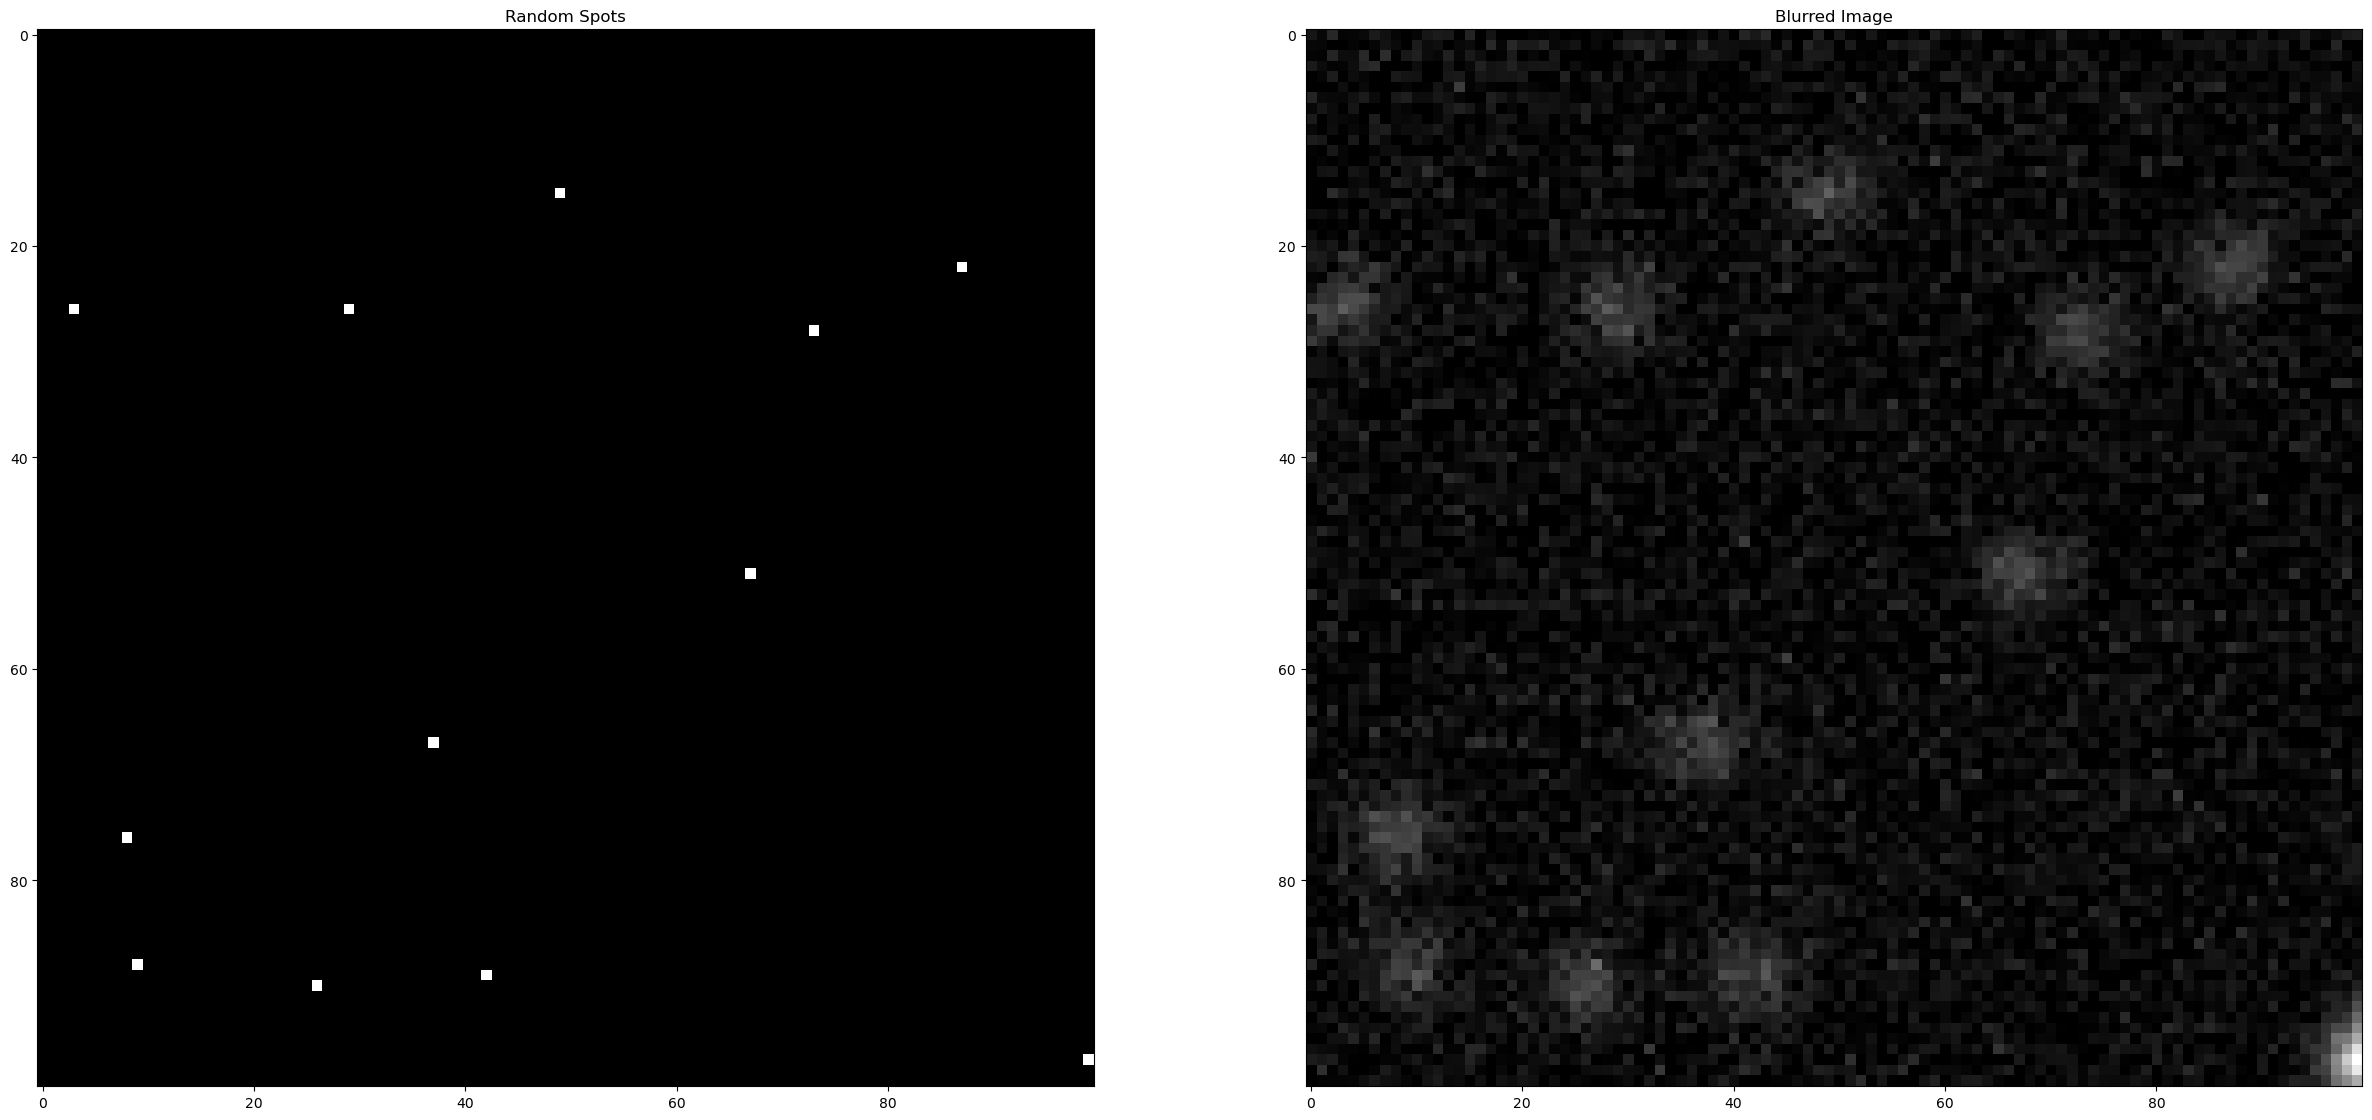

In [2]:
def generate_random_spots(image_size, num_spots):
    '''
    Generates num_spots randomly distributed spots in an image with image_size amount of pixels in x and y dimension each.
    '''
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    for _ in range(num_spots):
        x, y = np.random.randint(0, image_size, size=2)
        image[y, x] = 255  # Set pixel intensity to maximum (white) for the spot
    return image

def blur_image(image, blur_radius):
    '''
    Blurs the image with a given blur_radius.
    Also increases the pixel intensities of the blured spot pixels.
    '''
    blurred_image = gaussian(image, sigma = blur_radius, preserve_range = True)
    blurred_image = blurred_image*6
    return blurred_image

def add_random_noise(image, noise_sigma):
    '''
    Adds random noise with gaussian distribution around mean (loc) with certain sigma (scale) for a given image size
    '''
    noise = np.random.normal(loc=5, scale=noise_sigma, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 255)
    # noisy_image = (noisy_image * intensity_level / 255).astype(np.uint8)
    return noisy_image

def main(image_size = 100, num_spots = 100, gaussian_sigma = 1, fig_size_scaling = 1, display = True):

    # Generate random spots
    spots_image = generate_random_spots(image_size, num_spots)

    # Blur the image
    blurred_image = blur_image(spots_image, gaussian_sigma)

    # add noise
    noisy_image = add_random_noise(blurred_image, noise_sigma = 8)

    if display == True:
        fig, ax = plt.subplots(1,2, figsize = (10*fig_size_scaling,5*fig_size_scaling))
        ax[0].imshow(spots_image, cmap='gray')
        ax[0].set_title('Random Spots')
        # plt.axis('off')

        ax[1].imshow(noisy_image, cmap='gray')
        ax[1].set_title('Blurred Image')
    else:
        pass
    return noisy_image

    # plt.show()

if __name__ == "__main__":
    main(image_size = 100, num_spots = 12, gaussian_sigma = 2.7, fig_size_scaling=3, display = True)


# Simulating images based on spot data

In [3]:
def simulation(image_number, image_size, num_spots, gaussian_sigma):
    lis = list()
    for i in range(0, image_number):
        image = main(image_size = image_size, num_spots = num_spots, gaussian_sigma = gaussian_sigma, display = False)
        lis.append(image)
    return lis

I want to simulate a 100 uM3 STED image, being 2D but accounting for 500 nm z-depth. <br>
With the given xy pixel size, a single pixel has a volume of 0.0188764 uM x 0.0188764 uM x 0.5 uM = 0.00017816 uM3
To get to 100 uM3, we therefore need 100 uM3 / 0.00017816 uM3 = 561,293 (500 thousand) pixels, wich is 749 pixelsx749 pixels

### CTCF:
spot density eG1: 17.7 Poi/uM3   -> for 100 uM3: 1770   -> assuming 40% undercounting: 1770 x 1.67 = 2956<br>
spot density G1: 19.3 Poi/uM3    -> for 100 uM3: 1930   -> assuming 40% undercounting: 1930 x 1.67 = 3223

### STAG1:
spot density eG1: 22.8 Poi/uM3   -> for 100 uM3: 2280   -> assuming 40% undercounting: 2280 x 1.67 = 3808<br>
spot density G1: 20.2 Poi/uM3    -> for 100 uM3: 2020   -> assuming 40% undercounting: 2020 x 1.67 = 3373

### STAG2:
spot density eG1: 26.1 Poi/uM3   -> for 100 uM3: 2610   -> assuming 40% undercounting: 2610 x 1.67 = 4359<br>
spot density G1: 26.7 Poi/uM3    -> for 100 uM3: 2670   -> assuming 40% undercounting and 2 fold reduction in spot density: 2670 x 1.67 x2  = 8917

In [4]:
# updated
CTCF_eG1_images = simulation(image_number = 15, image_size = 750, num_spots = 2956, gaussian_sigma = 2.6)
CTCF_G1_images = simulation(image_number = 15, image_size = 750, num_spots = 3223, gaussian_sigma = 2.6)

STAG1_eG1_images = simulation(image_number = 15, image_size = 750, num_spots = 3808, gaussian_sigma = 2.6)
STAG1_G1_images = simulation(image_number = 15, image_size = 750, num_spots = 3373, gaussian_sigma = 2.6)

STAG2_eG1_images = simulation(image_number = 15, image_size = 750, num_spots = 4359, gaussian_sigma = 2.6)
STAG2_G1_images = simulation(image_number = 15, image_size = 750, num_spots = 8917, gaussian_sigma = 2.6)

In [5]:
plt.imshow(STAG1_G1_images[0])

In [8]:
# Define function to compute Pearson correlation between simulated STAG1/2 and CTCF channels
def Pearson(image_list_1, image_list_2):
    corr_list = list()
    for image_no in range(0, len(image_list_1)):
        image_ch1 = image_list_1[image_no]/255
        image_ch2 = image_list_2[image_no]/255
        correlation = ma.corrcoef(ma.masked_invalid(image_ch1.flatten()), ma.masked_invalid(image_ch2.flatten()))[1,0] #np.corrcoeff does not work with nan values, ma.corrcoeff with ma.masked_invalid does
        corr_list.append(correlation)
        # print(correlation)
    return corr_list

In [9]:
corr_eG1_STAG1 = Pearson(CTCF_eG1_images, STAG1_eG1_images)
corr_eG1_STAG2 = Pearson(CTCF_eG1_images, STAG2_eG1_images)
corr_G1_STAG1 = Pearson(CTCF_G1_images, STAG1_G1_images)
corr_G1_STAG2 = Pearson(CTCF_G1_images, STAG2_G1_images)

In [10]:
STAG1_eG1 = pd.DataFrame()
STAG1_eG1["corr"] = corr_eG1_STAG1
STAG1_eG1["stage"] = 'eG1'
STAG1_G1 = pd.DataFrame()
STAG1_G1["corr"] = corr_G1_STAG1
STAG1_G1["stage"] = 'G1'
STAG2_eG1 = pd.DataFrame()
STAG2_eG1["corr"] = corr_eG1_STAG2
STAG2_eG1["stage"] = 'eG1'
STAG2_G1 = pd.DataFrame()
STAG2_G1["corr"] = corr_G1_STAG2
STAG2_G1["stage"] = 'G1'
STAG1 = pd.concat([STAG1_eG1, STAG1_G1])
STAG2 = pd.concat([STAG2_eG1, STAG2_G1])
# STAG1

[Text(0, 0, 'early G1'), Text(1, 0, 'G1')]

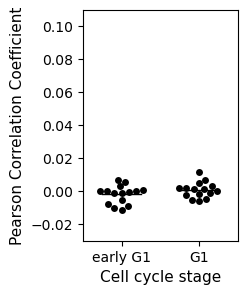

In [11]:
pal = {1: 'black', 2: 'grey', 3: 'lightgrey'}
fig, ax = plt.subplots(1,1, figsize = (2,3))

sns.swarmplot(data = STAG1, x = 'stage', y = 'corr', color = 'black', size = 5,ax = ax)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="stage",
            y="corr",
            data=STAG1,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax,
            width=0.5)

plt.ylim(-0.03,0.11)
plt.ylabel('Pearson Correlation Coefficient', fontsize = 11)
plt.xlabel('Cell cycle stage', fontsize = 11)
ax.set_xticklabels(['early G1', 'G1'], fontsize = 10)


In [12]:
pal = {1: 'black', 2: 'grey', 3: 'lightgrey'}
fig, ax = plt.subplots(1,1, figsize = (2,3))

sns.swarmplot(data = STAG2, x = 'stage', y = 'corr', color = 'black', ax = ax)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="stage",
            y="corr",
            data=STAG1,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax,
            width=0.5)

plt.ylim(-0.03,0.11)
plt.ylabel('Pearson Correlation Coefficient', fontsize = 11)
plt.xlabel('Cell cycle stage', fontsize = 11)
ax.set_xticklabels(['early G1', 'G1'], fontsize = 10)


[Text(0, 0, 'early G1'), Text(1, 0, 'G1')]

In [13]:
print("eG1: STAG1 & CTCF: \t\t" + str(round(np.mean(corr_eG1_STAG1),3)))
print("eG1: STAG2 & CTCF: \t\t" + str(round(np.mean(corr_eG1_STAG2),3)))
print("G1: STAG1 & CTCF: \t\t" + str(round(np.mean(corr_G1_STAG1),3)))
print("G1: STAG2 & CTCF: \t\t" + str(round(np.mean(corr_G1_STAG2),3)))

eG1: STAG1 & CTCF: 		-0.002
eG1: STAG2 & CTCF: 		-0.0
G1: STAG1 & CTCF: 		0.001
G1: STAG2 & CTCF: 		-0.001


# Checking efficiency of spot detection in simulated images

adapting spot analysis functions for single channel images

In [14]:
def spots_analysis_image(image, threshold_fact):
    gauss_filtered, thresh, binary, eroded, filtered, dilated, label_image = coarse_segment(image, erosion = True, dilation = True, area_threshold = 3, threshold_fact = threshold_fact)
    spot_labels = refine_segment(image, label_image, thresh)
    spot_measurements = extract_spot_int(image, spot_labels)
    return spot_measurements

### function to integrate all functions above, to output spot measurements and area for C2 and C4 in two dataframes.
def spot_summary(image_list, threshold_fact = 1.2):
    df = pd.DataFrame()
    list_image = list()
    for image in tqdm(range(0, len(image_list))):
        spot_measurements = spots_analysis_image(image_list[image], threshold_fact = threshold_fact)
        spot_measurements["image"] = image
        list_image.append(spot_measurements)
    df = pd.concat(list_image)
    return df

# Compare spot intensities at different spot densities

In [15]:
sim_500_spots = simulation(image_number = 5, image_size = 750, num_spots = 500, gaussian_sigma = 2.6) 
sim_2500_spots = simulation(image_number = 5, image_size = 750, num_spots = 2500, gaussian_sigma = 2.6)  #max spots detected per 100 uM3 = 2670
sim_5000_spots = simulation(image_number = 5, image_size = 750, num_spots = 5000, gaussian_sigma = 2.6)
sim_7500_spots = simulation(image_number = 5, image_size = 750, num_spots = 7500, gaussian_sigma = 2.6)
sim_10000_spots = simulation(image_number = 5, image_size = 750, num_spots = 10000, gaussian_sigma = 2.6)

In [25]:
df_sim_500 = spot_summary(sim_500_spots, threshold_fact = 1)
df_sim_2500 = spot_summary(sim_2500_spots, threshold_fact = 1)
df_sim_5000 = spot_summary(sim_5000_spots, threshold_fact = 1)
df_sim_7500 = spot_summary(sim_7500_spots, threshold_fact = 1)
df_sim_10000 = spot_summary(sim_10000_spots, threshold_fact = 1)

  0%|          | 0/5 [00:00<?, ?it/s]

Coarse segmentation DONE, threshold = 15.646388012277413
MAX spot_labels number: 0


 20%|██        | 1/5 [00:11<00:44, 11.05s/it]

MAX spot_labels number: 446
Coarse segmentation DONE, threshold = 15.759735163556927
MAX spot_labels number: 0


 40%|████      | 2/5 [00:21<00:32, 10.85s/it]

MAX spot_labels number: 455
Coarse segmentation DONE, threshold = 15.545795478266488
MAX spot_labels number: 0


 60%|██████    | 3/5 [00:34<00:23, 11.60s/it]

MAX spot_labels number: 450
Coarse segmentation DONE, threshold = 15.850654293223682
MAX spot_labels number: 0


 80%|████████  | 4/5 [00:45<00:11, 11.49s/it]

MAX spot_labels number: 453
Coarse segmentation DONE, threshold = 15.7854344799596
MAX spot_labels number: 0


100%|██████████| 5/5 [00:57<00:00, 11.41s/it]


MAX spot_labels number: 445


  0%|          | 0/5 [00:00<?, ?it/s]

Coarse segmentation DONE, threshold = 19.110049032715324
MAX spot_labels number: 0


 20%|██        | 1/5 [00:30<02:03, 30.77s/it]

MAX spot_labels number: 1694
Coarse segmentation DONE, threshold = 18.794017640090633
MAX spot_labels number: 0


 40%|████      | 2/5 [01:00<01:30, 30.20s/it]

MAX spot_labels number: 1658
Coarse segmentation DONE, threshold = 19.35966589789334
MAX spot_labels number: 0


 60%|██████    | 3/5 [01:31<01:00, 30.36s/it]

MAX spot_labels number: 1659
Coarse segmentation DONE, threshold = 19.053825913184546
MAX spot_labels number: 0


 80%|████████  | 4/5 [02:01<00:30, 30.52s/it]

MAX spot_labels number: 1671
Coarse segmentation DONE, threshold = 19.288228186311407
MAX spot_labels number: 0


100%|██████████| 5/5 [02:32<00:00, 30.47s/it]


MAX spot_labels number: 1657


  0%|          | 0/5 [00:00<?, ?it/s]

Coarse segmentation DONE, threshold = 24.15700861864049
MAX spot_labels number: 0


 20%|██        | 1/5 [00:36<02:26, 36.74s/it]

MAX spot_labels number: 2360
Coarse segmentation DONE, threshold = 24.634797921446655
MAX spot_labels number: 0


100%|██████████| 1435/1435 [00:33<00:00, 42.44it/s]


MAX spot_labels number: 2295


 40%|████      | 2/5 [01:13<01:49, 36.53s/it]

Coarse segmentation DONE, threshold = 24.585924288128936
MAX spot_labels number: 0


 60%|██████    | 3/5 [01:48<01:12, 36.11s/it]

MAX spot_labels number: 2330
Coarse segmentation DONE, threshold = 24.381528044766213
MAX spot_labels number: 0


 80%|████████  | 4/5 [02:24<00:36, 36.01s/it]

MAX spot_labels number: 2343
Coarse segmentation DONE, threshold = 24.952196765203574
MAX spot_labels number: 0


100%|██████████| 5/5 [02:59<00:00, 35.82s/it]


MAX spot_labels number: 2267


  0%|          | 0/5 [00:00<?, ?it/s]

Coarse segmentation DONE, threshold = 30.711953627273907
MAX spot_labels number: 0


 20%|██        | 1/5 [00:31<02:04, 31.06s/it]

MAX spot_labels number: 2302
Coarse segmentation DONE, threshold = 30.840901248108366
MAX spot_labels number: 0


 40%|████      | 2/5 [01:00<01:30, 30.22s/it]

MAX spot_labels number: 2285
Coarse segmentation DONE, threshold = 30.922874006436693
MAX spot_labels number: 0


 60%|██████    | 3/5 [01:31<01:00, 30.38s/it]

MAX spot_labels number: 2294
Coarse segmentation DONE, threshold = 30.791771159329805
MAX spot_labels number: 0


 80%|████████  | 4/5 [02:00<00:29, 29.99s/it]

MAX spot_labels number: 2334
Coarse segmentation DONE, threshold = 30.746928143741954
MAX spot_labels number: 0


100%|██████████| 5/5 [02:31<00:00, 30.22s/it]

MAX spot_labels number: 2296


  0%|          | 0/5 [00:00<?, ?it/s]

Coarse segmentation DONE, threshold = 38.02132684711731
MAX spot_labels number: 0


 20%|██        | 1/5 [00:24<01:38, 24.64s/it]

MAX spot_labels number: 2034
Coarse segmentation DONE, threshold = 37.06519294687986
MAX spot_labels number: 0


 40%|████      | 2/5 [00:47<01:10, 23.60s/it]

MAX spot_labels number: 2098
Coarse segmentation DONE, threshold = 37.23092208080989
MAX spot_labels number: 0


 60%|██████    | 3/5 [01:10<00:46, 23.19s/it]

MAX spot_labels number: 2067
Coarse segmentation DONE, threshold = 38.26025887989272
MAX spot_labels number: 0


 80%|████████  | 4/5 [01:34<00:23, 23.55s/it]

MAX spot_labels number: 2036
Coarse segmentation DONE, threshold = 37.48228319122194
MAX spot_labels number: 0


100%|██████████| 5/5 [01:58<00:00, 23.66s/it]

MAX spot_labels number: 2120


In [92]:
def compare_spot_intensity(df_list):
    fig, ax = plt.subplots(1,6, figsize = (25,3))
    ax_id = 0
    ax[0].set_ylabel('Density', fontsize = 20)
    for df in df_list:
        ax[ax_id].set_xlim(20,75)
        ax[ax_id].set_ylim(0,0.42)
        ax[ax_id].hist(x = df["intensity_mean"], bins = 40, density = True, color = 'black', alpha = 0.5)
        ax[ax_id].set_xlabel('Mean spot intensity (a.u.)', fontsize = 15)
        ax_id += 1
    for df in df_list:
        ax[-1].set_xlim(20,80)
        ax[-1].set_ylim(0,0.42)
        ax[-1].hist(x = df["intensity_mean"], bins = 40, density = True, alpha = 0.5)
        ax[-1].set_xlabel('Mean spot intensity (a.u.)', fontsize = 15)
        
    plt.show()

dfs = [df_sim_500, df_sim_2500, df_sim_5000, df_sim_7500, df_sim_10000]
compare_spot_intensity(dfs)

(array([1.51098172e-03, 1.00435844e-02, 4.30185385e-02, 1.04968789e-01,
        1.53497967e-01, 1.31633172e-01, 8.79035838e-02, 5.96393374e-02,
        4.54183330e-02, 4.68404334e-02, 4.42628764e-02, 4.78181275e-02,
        4.39073512e-02, 4.21297257e-02, 3.57302737e-02, 2.69310272e-02,
        2.22203195e-02, 1.86650683e-02, 1.56431049e-02, 1.03991095e-02,
        8.88812778e-03, 7.64378989e-03, 5.06623284e-03, 3.73301367e-03,
        2.39979450e-03, 2.57755706e-03, 2.13315067e-03, 1.15545661e-03,
        7.99931500e-04, 6.22168945e-04, 7.11050223e-04, 5.33287667e-04,
        1.77762556e-04, 1.77762556e-04, 8.88812778e-05, 8.88812778e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.77762556e-04]),
 array([28.8302067 , 29.80187639, 30.77354608, 31.74521577, 32.71688546,
        33.68855516, 34.66022485, 35.63189454, 36.60356423, 37.57523392,
        38.54690361, 39.5185733 , 40.490243  , 41.46191269, 42.43358238,
        43.40525207, 44.37692176, 45.34859145, 46.32026114,

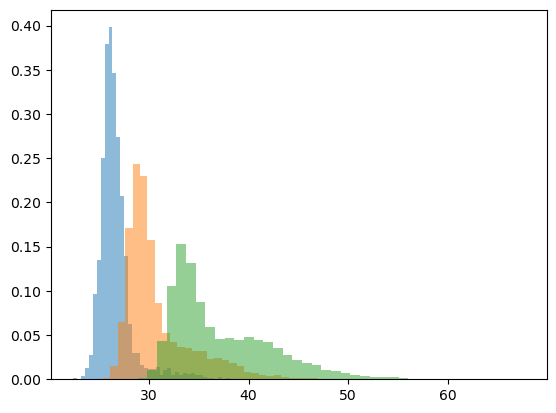

In [46]:
plt.hist(x = df_sim_500["intensity_mean"], bins = 40, density = True, alpha = 0.5)
plt.hist(x = df_sim_2500["intensity_mean"], bins = 40, density = True, alpha = 0.5)
plt.hist(x = df_sim_5000["intensity_mean"], bins = 40, density = True, alpha = 0.5)

# check out stats for simulated correlation data


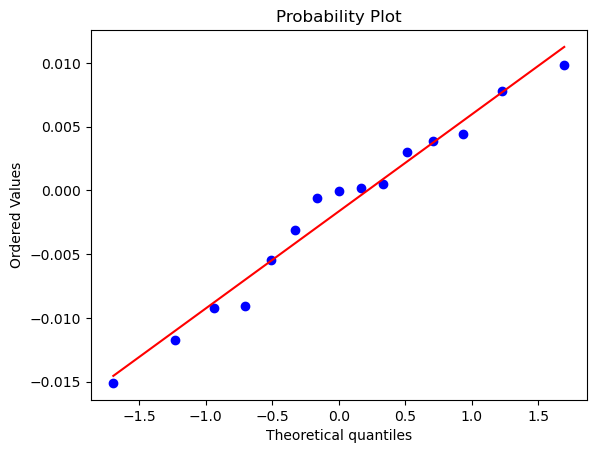

In [51]:
stats.probplot(corr_eG1_STAG2, dist="norm", plot=pylab)
pylab.show()

In [45]:
stats.ttest_ind(corr_eG1_STAG1, corr_G1_STAG1)

Ttest_indResult(statistic=-1.032877683918616, pvalue=0.3105004865016382)